In [121]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from keras.utils import to_categorical
from sklearn.metrics import balanced_accuracy_score

In [242]:
from sklearn.metrics import balanced_accuracy_score

# Function to calculate balanced accuracy
def balanced_accuracy(y_true, y_pred):
    return balanced_accuracy_score(y_true, y_pred) * 100

In [122]:
# Function to perform one-hot encoding for DNA sequences
def one_hot_encode(sequence):
    encoding = {'A': [1, 0, 0, 0], 'T': [0, 1, 0, 0], 'G': [0, 0, 1, 0], 'C': [0, 0, 0, 1]}
    one_hot_sequence = [encoding.get(base, [0, 0, 0, 0]) for base in sequence]
    return np.array(one_hot_sequence)

In [195]:
import torch
from torch import nn
# Make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [163]:
# Replace 'file_path.csv' with the path to your CSV file
file_path = '/mnt/raid1/thalassini/home/filtered_fimo/CTCF/datasets/data.csv'
df = pd.read_csv(file_path)
df

,data,class
0,CAAAAACACTGACAGGAAAAGGGATGGACATGATTCCCAGAATCCT...,0
1,CTAACCTGACATGAATTAGGGCAGGTTTTTGAATTCGTGTTGAAAA...,0
2,TCCTCTGTAGCACAGGTTAACACTTCTGCTAGTTCCAGGACTGAGG...,0
3,GAACACATTAAACAGCAGGTTGCTTATTCCTTCTCAAACCGCACTA...,0
4,ATTTCTCGGAACAGGCAGAAAGGAAGCGGCAGGGAGGTGGGTACTC...,0
...,...,...
96489,CCACCCTCCACTCCTCACCCCTCATCCCTCACCACCTGCCTTTCAA...,1
96490,GGCGGTGACGCACGGCGCGGTGACGCAGCGCGACGGCGGCGGCGGC...,1
96491,GGCGGTGACGCACGGCGCGGTGACGCAGCGCGACGGCGGCGGCGGC...,1
96492,CTCCCTCTCTGATGCCTGGTCACACCAGGATGGCGGTACCATGTGC...,1


Max length:218, Min length: 200


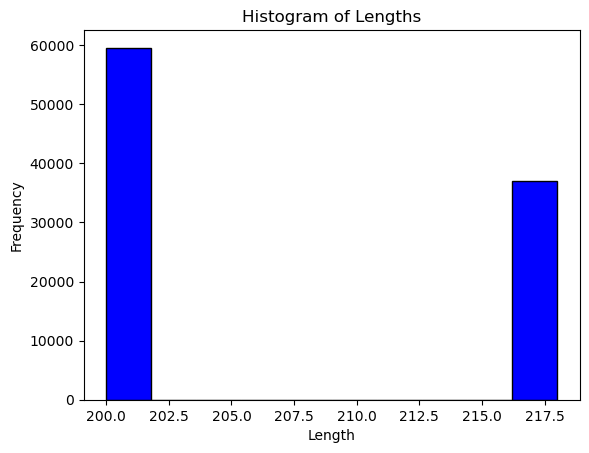

In [144]:
lengths= [len(item) for item in df['data']] 
print(f'Max length:{max(lengths)}, Min length: {min(lengths)}')
import matplotlib.pyplot as plt
# Plotting the histogram
plt.hist(lengths, bins=10, color='blue', edgecolor='black')
plt.title('Histogram of Lengths')
plt.xlabel('Length')
plt.ylabel('Frequency')
plt.show()

In [145]:
# Find the maximum length of sequences
#min_length = min(len(seq) for seq in df['data'])
limit=200


# Pad or cut sequences to ensure they all have the same length
cut_sequences = [seq[:limit] for seq in df['data']]

# Update the DataFrame with the cut sequences
#df['data'] = cut_sequences

In [146]:
lengths= [len(item) for item in cut_sequences]
print(f'Max length:{max(lengths)}, Min length: {min(lengths)}')

Max length:200, Min length: 200


# Define X,y variables

In [147]:
X=[one_hot_encode(sequence) for sequence in cut_sequences]

In [151]:
X = torch.from_numpy(X).type(torch.float)


In [148]:
X=np.array(X)
X.shape

(96494, 200, 4)

In [250]:
y=np.array(df['class'])
y[:3]

array([0, 0, 0])

In [251]:
y = torch.from_numpy(y).type(torch.float)

In [268]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit



# Split the data into a stratified hold-out validation set and the rest
stratified_splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_val_index, test_index in stratified_splitter.split(X, y):
    X_train_val, X_test = X[train_val_index], X[test_index]
    y_train_val, y_test = y[train_val_index], y[test_index]

# Split the remaining data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, stratify=y_train_val, random_state=42)

print(len(X_train), len(y_train), len(X_val), len(y_val))
print(len(X_test), len(y_test))


# (X_train, X_val, y_train, y_val) for training, validation
# X_test, y_test for the final hold-out validation.


61756 61756 15439 15439
19299 19299


In [269]:
torch.manual_seed(42)
# Expand the dimensions of y_train to make it 2-dimensional
y_train = y_train.view(-1, 1)
y_test = y_test.view(-1,1)
y_val = y_val.view(-1,1)
# Concatenate the complement of y_train to create a 2-dimensional tensor
y_train_one_hot = torch.cat([1 - y_train, y_train], dim=1).float()
y_test_one_hot = torch.cat([1 - y_test, y_test], dim=1).float()
y_val_one_hot = torch.cat([1 - y_val, y_val], dim=1).float()

# Move tensors to the same device
X_train, y_train_one_hot, y_train = X_train.to(device), y_train_one_hot.to(device), y_train.to(device)
X_val, y_val_one_hot, y_val = X_val.to(device), y_val_one_hot.to(device), y_val.to(device)
X_test, y_test_one_hot, y_test = X_test.to(device), y_test_one_hot.to(device), y_test.to(device)


print(X_train.size(0), y_train_one_hot.size(0), y_train.size(0))
# Create datasets
train_dataset = TensorDataset(X_train, y_train_one_hot, y_train)
val_dataset = TensorDataset(X_val, y_val_one_hot, y_val)
test_dataset = TensorDataset(X_test, y_test_one_hot, y_test)



61756 61756 61756


In [270]:
from torch.utils.data import DataLoader, TensorDataset
batch_size=64
torch.manual_seed(42)
# Convert to PyTorch DataLoader

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

# 1 layer CNN

In [286]:
class Conv_v0(torch.nn.Module):

    def __init__(self):
        super(Conv_v0, self).__init__()

        self.conv1 = torch.nn.Conv1d(in_channels=4, out_channels=3, kernel_size=17)
        self.activation = torch.nn.ReLU()
        self.maxpool = torch.nn.MaxPool1d(kernel_size=5)
        
        self.dropout = torch.nn.Dropout(p=0.5) 
        self.fc = torch.nn.Linear(in_features=108, out_features=2)
        #elf.sigmoid = torch.nn.Sigmoid()

    def forward(self, x):
        x= x.permute(0, 2, 1)
        x = self.conv1(x)
        x = self.activation(x)
        x = self.maxpool(x)
        
        # Reshape the output of the max pooling layer before passing it to the fully connected layer
        x = x.view(x.size(0), -1)
        #print("Size after reshaping:", x.size())
        x=self.dropout(x)
  
    
        
        x = self.fc(x)
       #x = self.sigmoid(x)
        return x


In [287]:
# Create an instance of the Conv_v0 model
torch.manual_seed(42)
model = Conv_v0()

# Generate random input data
random_data = torch.rand((61756, 200, 4))

# Pass the random data through the model
result = model(random_data)

print(result)


tensor([[-0.0455, -0.0595],
        [-0.1923, -0.6890],
        [-0.4030, -0.2121],
        ...,
        [-0.4391, -0.2598],
        [-0.2159, -0.1918],
        [-0.3173, -0.4356]], grad_fn=<AddmmBackward0>)


In [288]:
# View the frist 5 outputs of the forward pass on the test data
y_logits = model(X_test.to(device))[:5]
y_logits

tensor([[-0.5399, -0.4358],
        [-0.1775, -0.1294],
        [-0.1751,  0.2937],
        [-0.0316,  0.0428],
        [-0.0760, -0.4730]], grad_fn=<SliceBackward0>)

# Set up loss function and optimizer

In [289]:
torch.manual_seed(42)
# Create an instance of the Conv_v0 model
model = Conv_v0()

In [290]:
# Create a loss function
# loss_fn = nn.BCELoss() # BCELoss = no sigmoid built-in
loss_fn = nn.BCEWithLogitsLoss() # BCEWithLogitsLoss = sigmoid built-in

# Create an optimizer
optimizer = torch.optim.SGD(params=model.parameters(), 
                            lr=0.001)

In [291]:
torch.manual_seed(42)
# Training and evaluation loop
epochs = 10  # You can adjust the number of epochs
for epoch in range(epochs):
    ### Training
    model.train()

    for X_train, y_train_one_hot, y_train in train_loader:
        # Move data to the device if needed
        X_train, y_train = X_train.to(device), y_train.to(device)

        # 1. Forward pass (model outputs raw logits)
        y_logits = model(X_train)#.squeeze()
        y_pred = torch.round(torch.sigmoid(y_logits))
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        #print(y_logits.shape,y_pred_class.shape,y_train.shape)
        


        # 2. Calculate loss/accuracy
        loss = loss_fn(y_logits, y_train_one_hot)
        acc = balanced_accuracy(y_true=y_train.detach().numpy(), 
                                y_pred=y_pred_class.detach().numpy())

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

    ### Validation
    model.eval()
    with torch.no_grad():
        for X_val, y_val_one_hot, y_val in val_loader:
            # Move data to the device if needed
            X_val, y_val = X_val.to(device), y_val.to(device)

            # 1. Forward pass
            val_logits = model(X_val).squeeze()
            val_pred = torch.round(torch.sigmoid(val_logits))
            

            # 2. Calculate loss/accuracy
            val_loss = loss_fn(val_logits, y_val_one_hot)
            val_pred_class = torch.argmax(torch.softmax(val_pred, dim=1), dim=1)
        
            val_acc = balanced_accuracy(y_true=y_val.cpu().numpy(),
                                        y_pred=val_pred_class.cpu().numpy())

    # Print out what's happening every epoch
    print(f"Epoch: {epoch + 1} | Train Loss: {loss:.5f}, Train Acc: {acc:.2f}% | Val Loss: {val_loss:.5f}, Val Acc: {val_acc:.2f}%")

Epoch: 1 | Train Loss: 0.68226, Train Acc: 46.65% | Val Loss: 0.70891, Val Acc: 50.00%
Epoch: 2 | Train Loss: 0.70926, Train Acc: 51.85% | Val Loss: 0.53002, Val Acc: 50.00%
Epoch: 3 | Train Loss: 0.72819, Train Acc: 50.00% | Val Loss: 0.64226, Val Acc: 50.00%
Epoch: 4 | Train Loss: 0.58969, Train Acc: 50.00% | Val Loss: 0.61843, Val Acc: 50.00%
Epoch: 5 | Train Loss: 0.60288, Train Acc: 50.00% | Val Loss: 0.60176, Val Acc: 50.00%
Epoch: 6 | Train Loss: 0.64598, Train Acc: 52.27% | Val Loss: 0.66298, Val Acc: 50.00%
Epoch: 7 | Train Loss: 0.60109, Train Acc: 47.62% | Val Loss: 0.56262, Val Acc: 50.00%
Epoch: 8 | Train Loss: 0.57329, Train Acc: 57.89% | Val Loss: 0.58741, Val Acc: 50.00%
Epoch: 9 | Train Loss: 0.60782, Train Acc: 48.33% | Val Loss: 0.47724, Val Acc: 50.00%
Epoch: 10 | Train Loss: 0.50053, Train Acc: 65.62% | Val Loss: 0.56098, Val Acc: 70.00%
